In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind

In [3]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)

# Part 2 - Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

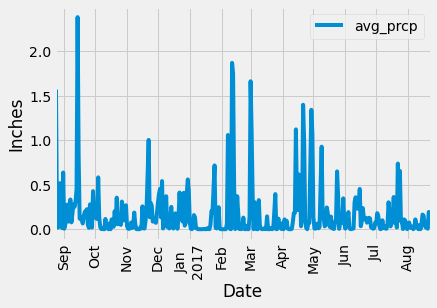

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# one_year_from_latest_record = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
query = f'''
    SELECT
        date,
        AVG(prcp) as avg_prcp
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
    GROUP BY
        date
    ORDER BY
        date

'''
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql(query, conn)

prcp_df['date'] = pd.to_datetime(prcp_df['date'])

# Sort the dataframe by date
#prcp_df.sort_values('date')

# Set the index to date
prcp_df.set_index('date', inplace = True)


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [8]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,avg_prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [9]:
# Design a query to show how many stations are available in this dataset?
query = '''
    SELECT
        COUNT(*) AS station_count
    FROM
        station
'''

station_df = pd.read_sql(query, conn)
station_count = station_df['station_count'].values[0]
print(f'There are {station_count} stations in the database.')

There are 9 stations in the database.


In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
    SELECT
        s.station AS station_code,
        s.name AS station_name,
        COUNT(*) AS station_count
    FROM
        measurement m
    INNER JOIN station s
    ON m.station = s.station
    GROUP BY
        s.station,
        s.name
    ORDER BY 
        station_count DESC
'''
active_stations_df = pd.read_sql(query, conn)
active_stations_df

,station_code,station_name,station_count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_stations_df.sort_values('station_count', ascending=False, inplace=True)
most_active_station = active_stations_df['station_code'].values[0]
most_active_station
query = f'''
    SELECT
        MIN(tobs) AS min_tobs,
        MAX(tobs) AS max_tobs,
        AVG(tobs) AS avg_tobs
    FROM
        measurement
    WHERE 
        station = '{most_active_station}'
'''
max_min_temp_obs_df = pd.read_sql(query, conn)
max_min_temp_obs_df

,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


Text(0, 0.5, 'Number of Observations')

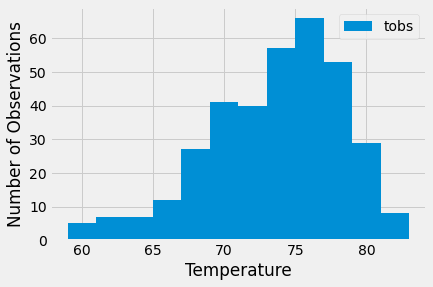

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = f'''

    SELECT
        date,
        tobs
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
        AND
        station = '{most_active_station}'
'''
temp_obs_df = pd.read_sql(query,conn)
temp_obs_df.plot.hist(bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Number of Observations')

In [13]:
# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
# You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

query =f'''
    SELECT 
        tobs
    FROM
        measurement
    WHERE
        date LIKE '%-06-%'
'''
june = pd.read_sql(query, conn)

query =f'''
    SELECT 
        tobs
    FROM
        measurement
    WHERE
        date LIKE '%-12-%'
'''
dec = pd.read_sql(query,conn)

res = scipy.stats.ttest_ind(june, dec, equal_var=True)
display(res)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [14]:
# above results indicate that the june and dec temps (71 vs. 74 degrees) are actually
# different from each other.  Though statistically significant, this difference is not
# practically significant.  We used a paired t test b/c we were sampling the same thing
# at different times.

## Part 3 - Data Analysis Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # your code here
    query = f'''
        SELECT
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM
            measurement
        WHERE 
            date BETWEEN '{start_date}' AND '{end_date}'
    '''
    temp_stats_df = pd.read_sql(query, conn)
    temp_stats = tuple(temp_stats_df.values[0])
    
    return temp_stats
    
    

# function usage example
print(calc_temps('2017-01-01', '2017-12-31'))

(58.0, 87.0, 74.14387974230493)


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temps = calc_temps('2010-12-01', '2010-12-31')
my_trip_temps




(58.0, 80.0, 70.20851063829787)

(0.0, 110.0)

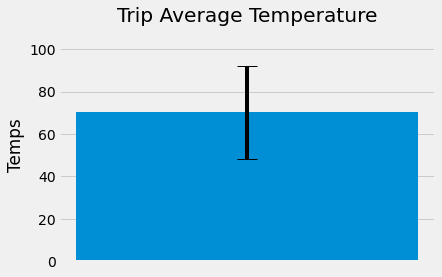

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = my_trip_temps[2]
yerr = my_trip_temps[1] - my_trip_temps[0]
x_pos = 1

fig, ax = plt.subplots()
ax.bar(x_pos, y, yerr=yerr, align='center', alpha=1, ecolor='black', capsize=10)
ax.set_ylabel('Temps')
ax.set_xticks([0])
ax.set_title('Trip Average Temperature')
ax.yaxis.grid(True)
ax.set_ylim(0,110)



In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = f'''
    SELECT
        s.station AS station_code,
        s.name AS station_name,
        s.latitude,
        s.longitude,
        s.elevation,
        SUM(prcp) AS 'Total Rainfall'
    FROM
        measurement m
    INNER JOIN station s
    ON m.station = s.station
    WHERE
        date BETWEEN '2010-12-01' AND '2010-12-10'
    GROUP BY 
        s.station
    ORDER BY
        SUM(prcp) DESC
'''
total_rainfall = pd.read_sql(query, conn)
total_rainfall

,station_code,station_name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.30
1,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,5.08
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.77
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.00
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.73
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.44
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.26
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1.98
8,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.62


In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    # your code here
    
    query = f'''
        SELECT
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM
            measurement
        WHERE 
            date LIKE '%-{date}'
    '''
    day_temps_df = pd.read_sql(query, conn)
    day_temps = tuple(day_temps_df.values[0])
    
    return day_temps
    
    
    return # your code here
    
test = daily_normals("03-04")
test

(57.0, 77.0, 69.27272727272727)

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2020-12-01'
end_date = '2020-12-10'

# Use the start and end date to create a range of dates
vacation_dates = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings
vacation_days = vacation_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in vacation_days:
    normals.append(daily_normals(day))
normals

[(65.0, 78.0, 71.91666666666667),
 (62.0, 77.0, 71.32692307692308),
 (67.0, 79.0, 72.88679245283019),
 (66.0, 81.0, 72.17647058823529),
 (64.0, 78.0, 70.92156862745098),
 (61.0, 78.0, 69.3921568627451),
 (58.0, 79.0, 69.2),
 (60.0, 83.0, 70.27450980392157),
 (64.0, 80.0, 71.90196078431373),
 (61.0, 78.0, 71.24528301886792)]

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tmax', 'tavg'])
df['date'] = vacation_dates
df.set_index('date', inplace = True)
df

,tmin,tmax,tavg
date,,,
2020-12-01,65.0,78.0,71.916667
2020-12-02,62.0,77.0,71.326923
2020-12-03,67.0,79.0,72.886792
2020-12-04,66.0,81.0,72.176471
2020-12-05,64.0,78.0,70.921569
2020-12-06,61.0,78.0,69.392157
2020-12-07,58.0,79.0,69.200000
2020-12-08,60.0,83.0,70.274510
2020-12-09,64.0,80.0,71.901961


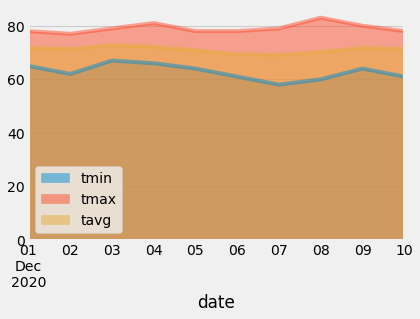

In [22]:
df.plot(kind='area', stacked=False)